<a href="https://colab.research.google.com/github/brunobro/eucalyptus-growth-recognition-using-machine-learning-methods-and-spectral-variables/blob/main/Scripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Eucalyptus growth recognition using machine learning methods and spectral variables**

**Postdoctoral work - UFMS Chapadão do Sul campus**

Student: Bruno Rodrigues de Oliveira

Advisor: Paulo Eduardo Teodoro

Step 1: Clustering to find groups based on measurements of Ht (total height) and DBH (diameter at breast height) of Eucalyptus trees

Step 2: Classification in the groups obtained, using the vegetation indices measured by the UAV

**Please cite this research accordingly: https://www.sciencedirect.com/science/article/abs/pii/S0378112721005867 or https://doi.org/10.1016/j.foreco.2021.119496**


In [2]:
'''
Importing required libraries
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, auc
from scipy.spatial import distance

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


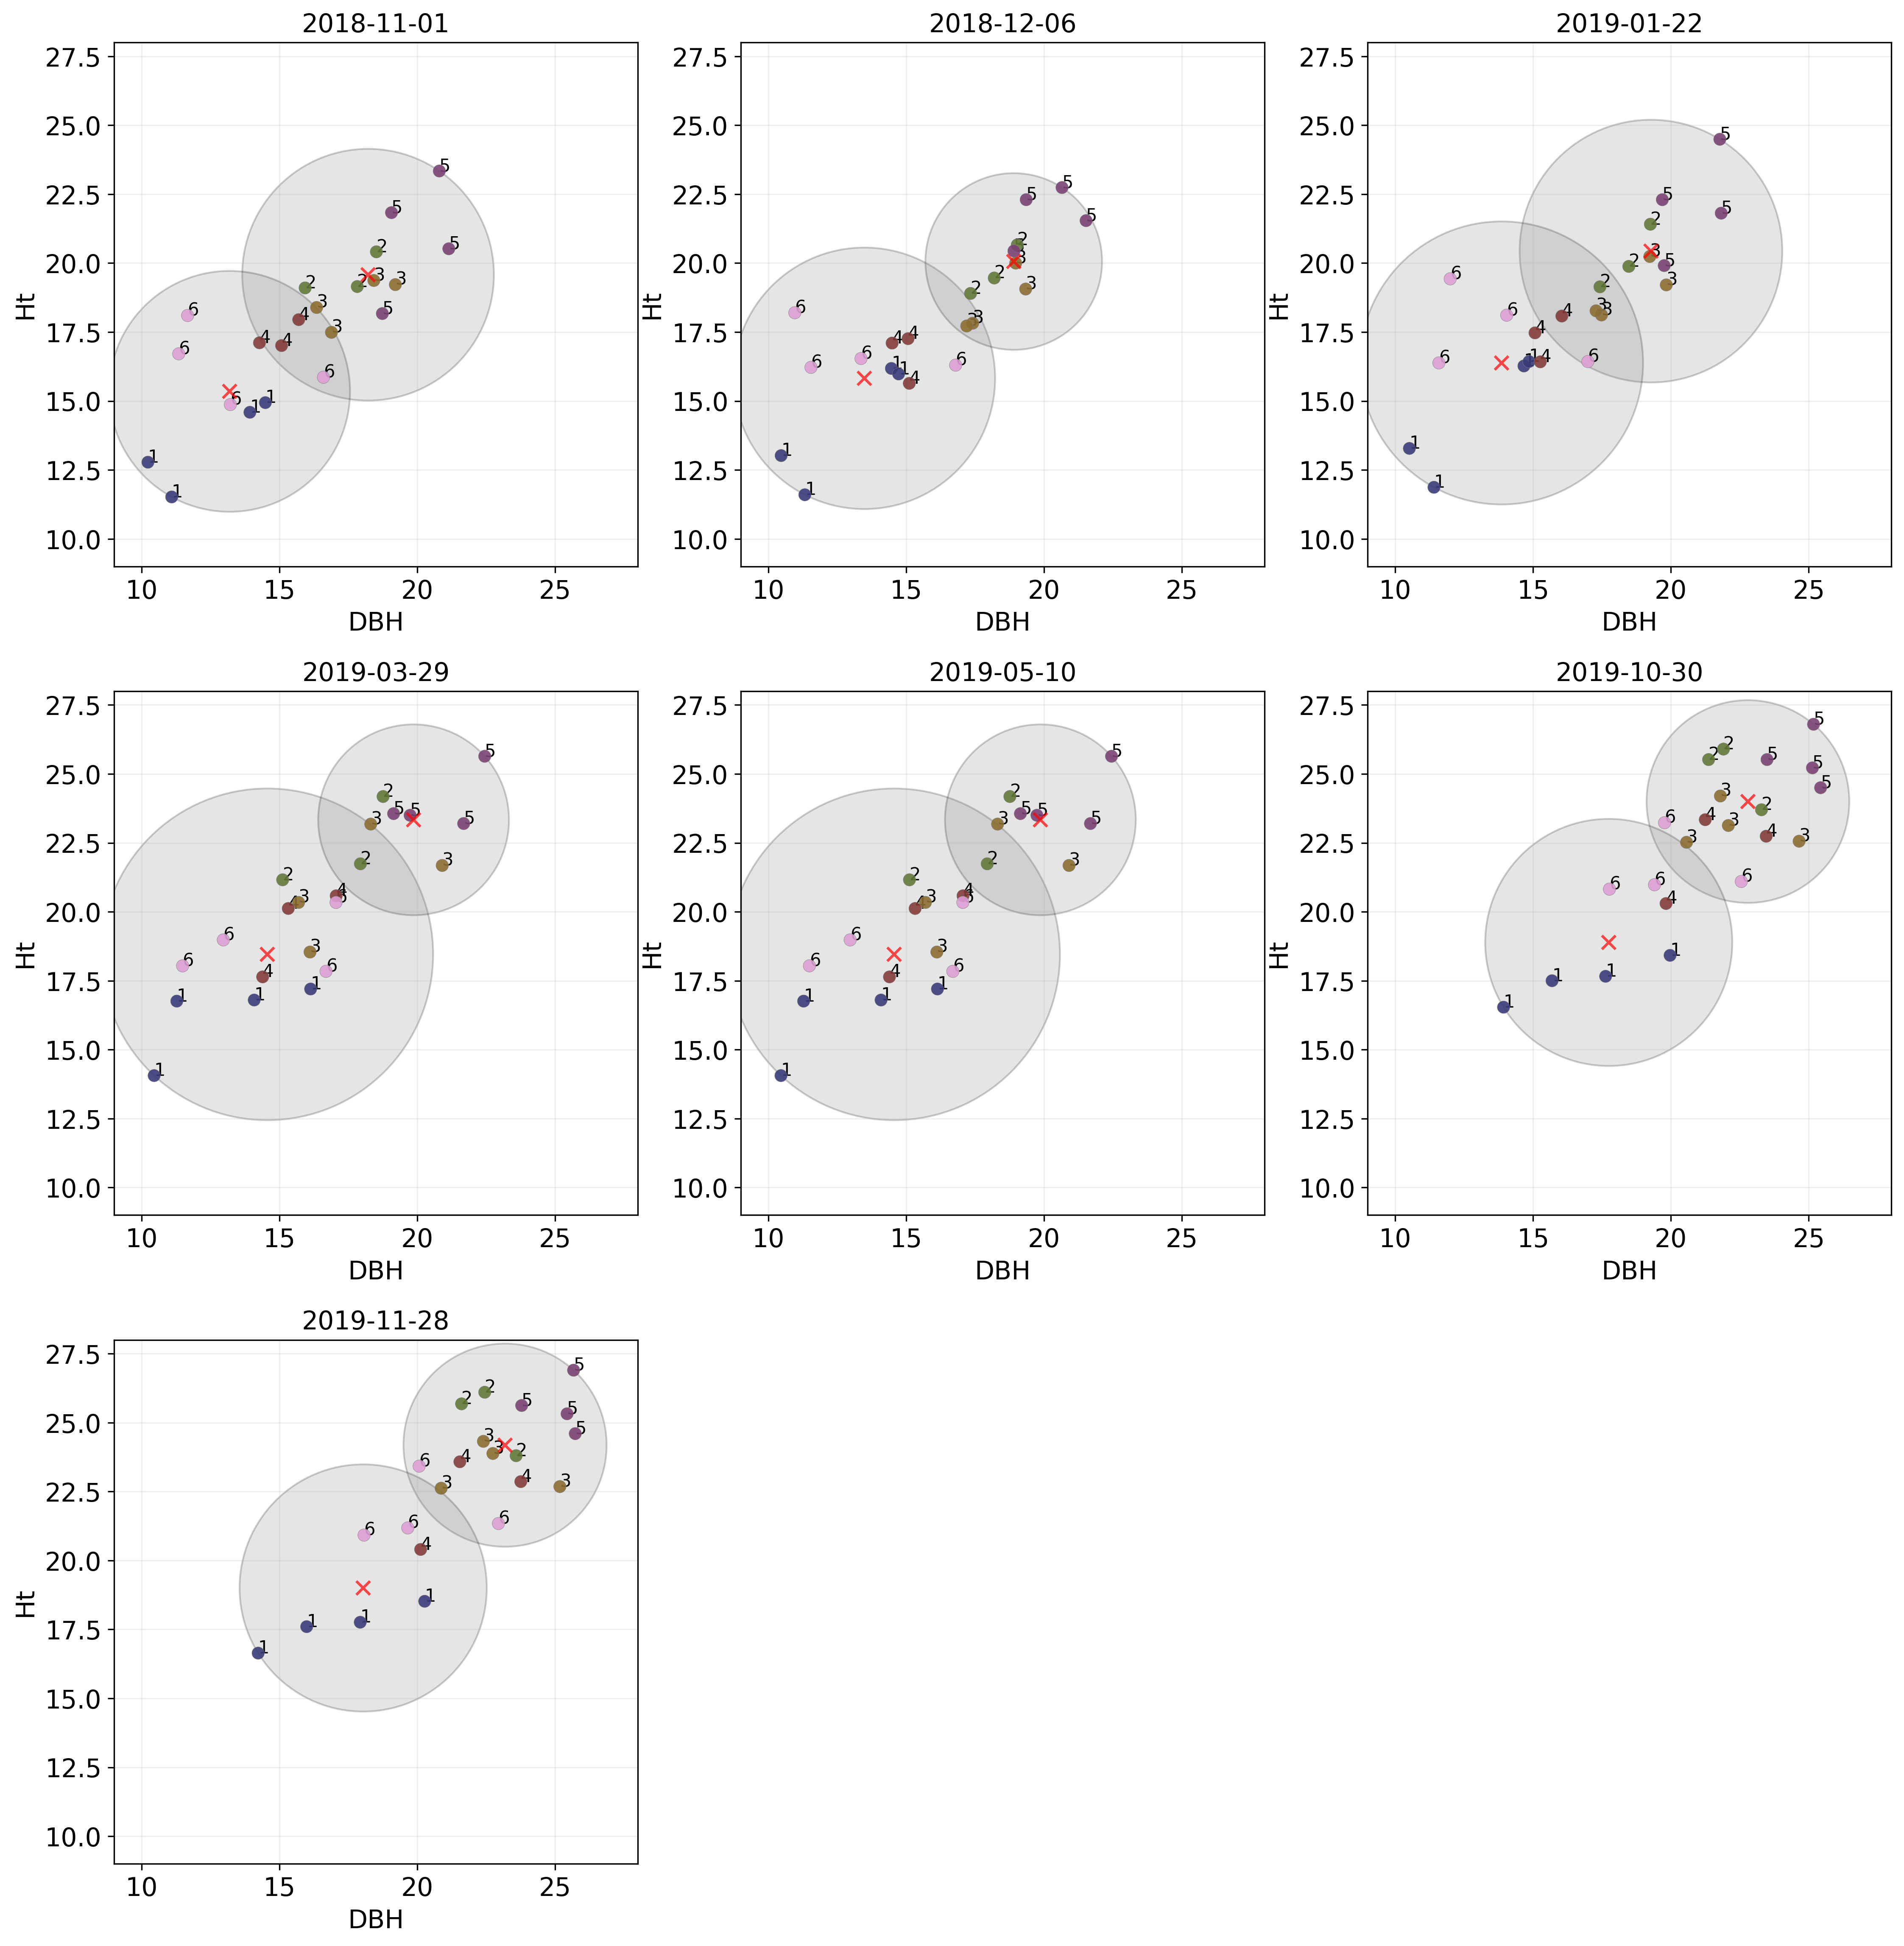

In [3]:
'''
Data preparation
'''
df = pd.read_excel('data.xlsx')                 
df.dropna(inplace=True) #Delete empty records

#Name of Eucalyptus species
Species = ['E. camaldulensis', 'E. urograndis', 'E. saligna', 'E. urophylla', 'E. grandis', 'Corymbia citriodora']

#Get the available dates
dates = np.unique(df['Data'].dt.strftime('%Y-%m-%d'))

'''
Does the clustering on each collected date
'''
plt.figure(dpi=300, figsize=(15, 20))

dataframes = []
straights  = []

k = 1

for date in dates:
  new_df = df.loc[df['Data'] == date]
  cls_df = np.array(new_df['Species'])  #Dataframe with individual information
  new_df = np.array(new_df[['DAP','Ht']]) #Create a dataframe with only these columns
  dataframes.append(new_df)

  #Clusters K means
  KM = KMeans(n_clusters=2, random_state=0).fit(new_df)
  labels    = KM.labels_
  centroids = KM.cluster_centers_
  
  ax = plt.subplot(4, 3, k)
  plt.scatter(new_df[:, 0], new_df[:, 1], c=cls_df, alpha=0.9, s=50, edgecolors='gray', linewidth=0.2, cmap='tab20b', zorder=10000)
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=60, linewidths=3, c=['r','r'], zorder=100000, alpha=0.7)
  plt.xlim((9, 28))
  plt.ylim((9, 28))
  
  '''
  Calculates the radius of the circles that delimit the groups having the centroids as the center
  '''
  a0 = (centroids[0,0], centroids[0,1])
  a1 = (centroids[1,0], centroids[1,1])
  r0, r1 = 0, 0

  for i in range(0, len(new_df)):
    b = (new_df[i,0], new_df[i,1])
 
    if labels[i] == 0:
      dist = distance.euclidean(a0, b)
      if dist > r0:
        r0 = dist
    else:
      dist = distance.euclidean(a1, b)
      if dist > r1:
        r1 = dist

  c1 = plt.Circle((centroids[0,0], centroids[0,1]), r0, edgecolor='k', facecolor='gray', alpha=0.2)
  c2 = plt.Circle((centroids[1,0], centroids[1,1]), r1, edgecolor='k', facecolor='gray', alpha=0.2)

  ax.add_patch(c1)
  ax.add_patch(c2)

  ax.set_aspect('equal')
  ax.set_title(date)
  ax.grid(alpha=0.2)
  ax.set_xlabel('DBH')
  ax.set_ylabel('Ht')
  
  for i, txt in enumerate(cls_df):
    txt = str(int(txt))
    txt = txt.replace('[','').replace(']','')
    plt.annotate(txt, (new_df[:, 0][i], new_df[:, 1][i]), fontsize=10)
  
  k += 1

plt.tight_layout()
plt.show()


In [6]:
'''
By analyzing the first figures above, the following attribution is made
Species [1, 4, 6] -> slow growth
Species [2, 3, 5] -> fast growth
'''

sg = [1, 4, 6]
fg = [2, 3, 5]

#Class of each species (slow growth -> 0) ou (fast growth -> 1)
Classes = []
for specie in df['Species']:
  if specie in sg:
    Classes.append(0)
  else:
    Classes.append(1)

Classes = np.array(Classes)

#Excludes columns that will not be used in sorting
df.drop(columns=['Data', 'Bloco','DAP','Ht','Species'], inplace=True)

#Data for sorting with all attributes
data_classification = np.array(df)

In [7]:
'''
Statistical analysis of attribute selection
'''

#Select all attributes for analysis
sel_k = SelectKBest(f_classif, k='all')
sel_k.fit_transform(data_classification, Classes)

print('Attributes')
print(np.array(df.columns))
print('Scores: ')
print(np.round(sel_k.scores_, 4))
print('p-values: ')
print(np.round(sel_k.pvalues_, 4))

Attributes
['green' 'red' 'rededge' 'NIR' 'NDVI' 'SAVI' 'NDRE' 'GNDVI' 'EVI' 'SCCCI'
 'ATSAVI' 'ARVI2' 'CCCI' 'Ciredge' 'GDVI' 'EVEI2' 'GSAVI' 'GRNDVI' 'IPVI'
 'Norm R1' 'Norm R2' 'Norm R3' 'NGRDI' 'RGR' 'SRRed/NIR' 'WDRVI' 'BWDRVI']
Scores: 
[2.7577e+00 7.5490e-01 1.9190e-01 1.0446e+00 2.7622e+00 9.1640e-01
 3.4900e-01 2.7622e+00 4.3400e-02 1.1760e-01 2.4636e+00 2.7622e+00
 1.6744e+00 4.2130e-01 1.7403e+00 1.8980e+00 3.5990e+00 9.7000e-03
 2.7637e+00 1.0807e+01 5.6625e+00 2.4848e+00 4.2500e-01 3.4090e-01
 2.7539e+00 2.7622e+00 7.9780e-01]
p-values: 
[0.0989 0.3863 0.662  0.3084 0.0986 0.3399 0.5556 0.0986 0.8352 0.7321
 0.1186 0.0986 0.1976 0.5173 0.1891 0.1703 0.0597 0.9218 0.0985 0.0013
 0.0186 0.117  0.5155 0.5602 0.0991 0.0986 0.3732]


In [8]:
'''
Makes the classification by selecting the vegetation indices
Compare several algorithms: to make the comparison, just comment the codes
below for that algorithm you intend to use
'''

#Returns the highest K values
def higher(values, K):
  ind = []

  for k in range(0, K):
    j = np.argmax(values)
    ind.append(j)
    del values[j]
  
  return ind

#To vary the amount of attributes selected
ti   = np.arange(1, data_classification.shape[1] + 1)

for K_attr in ti:

  #Select the best K_attr attributes
  sel_k     = SelectKBest(f_classif, k='all')
  data_less = sel_k.fit_transform(data_classification, Classes)

  #Show the chosen attributes
  print('Features: ')
  ind = np.argpartition(sel_k.scores_, -K_attr)[-K_attr:]
  for i, col in enumerate(df.columns):
    if i in ind:
      print(col, end=" ")
  print('\n')

  '''
  #Random Forest
  parameters = {
      'n_estimators':(10, 100, 200), 
      'criterion'   : ('gini', 'entropy'),
      'class_weight': ('balanced', 'balanced_subsample')
  }
  clf = RandomForestClassifier(random_state=0)
  '''

  #Extra Tree
  parameters = {
      'n_estimators':(10, 100, 200), 
      'criterion'   : ('gini', 'entropy'),
      'class_weight': ('balanced', 'balanced_subsample')
  }
  clf = ExtraTreesClassifier(random_state=0)

  '''
  #KNN
  parameters = {
      'n_neighbors':(2, 5, 10), 
      'weights'   : ('uniform', 'distance'),
      'algorithm': ('ball_tree', 'kd_tree', 'brute')
  }
  clf = KNeighborsClassifier()
  '''

  '''
  #SVM
  parameters = {
      'C':(1, 1.5, 2.0, 2.5, 3.0), 
      'kernel'   : ('linear', 'rbf', 'sigmoid'),
      'gamma': ('scale', 'auto')
  }
  clf = SVC(random_state=0)
  '''

  #MLP
  '''
  parameters = {
      'hidden_layer_sizes':((100, 50), (50, 100), (10, 10), (10, 5), (100, 200), (100, 200, 300), (20, 10, 5)), 
      'activation'        : ('tanh', 'relu', 'logistic'),
      'learning_rate': ('constant', 'invscaling', 'adaptive')
  }
  clf = MLPClassifier(random_state=0, max_iter=1000)
  '''

  #Gaussian Process
  '''
  parameters = {
      'kernel': (1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()), 
  }
  clf = GaussianProcessClassifier(random_state=0)
  '''

  #GridSearch: looks for the parameters that generate the improved accuracy
  Gs = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, n_jobs=3)
  Gs.fit(data_less, Classes)

  best_params = Gs.best_params_
  best_result = Gs.best_score_

  print('\nResults for %i attributes' %K_attr)
  print(best_params)
  print(best_result)


Features: 
Norm R1 


Results for 1 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
Norm R1 Norm R2 


Results for 2 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
GSAVI Norm R1 Norm R2 


Results for 3 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
GSAVI IPVI Norm R1 Norm R2 


Results for 4 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
NDVI GSAVI IPVI Norm R1 Norm R2 


Results for 5 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
NDVI GNDVI GSAVI IPVI Norm R1 Norm R2 


Results for 6 attributes
{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.7037500000000001
Features: 
NDVI GNDVI ARVI2 GSAVI IPVI Norm R1 Norm R2 


Results for 7 attributes


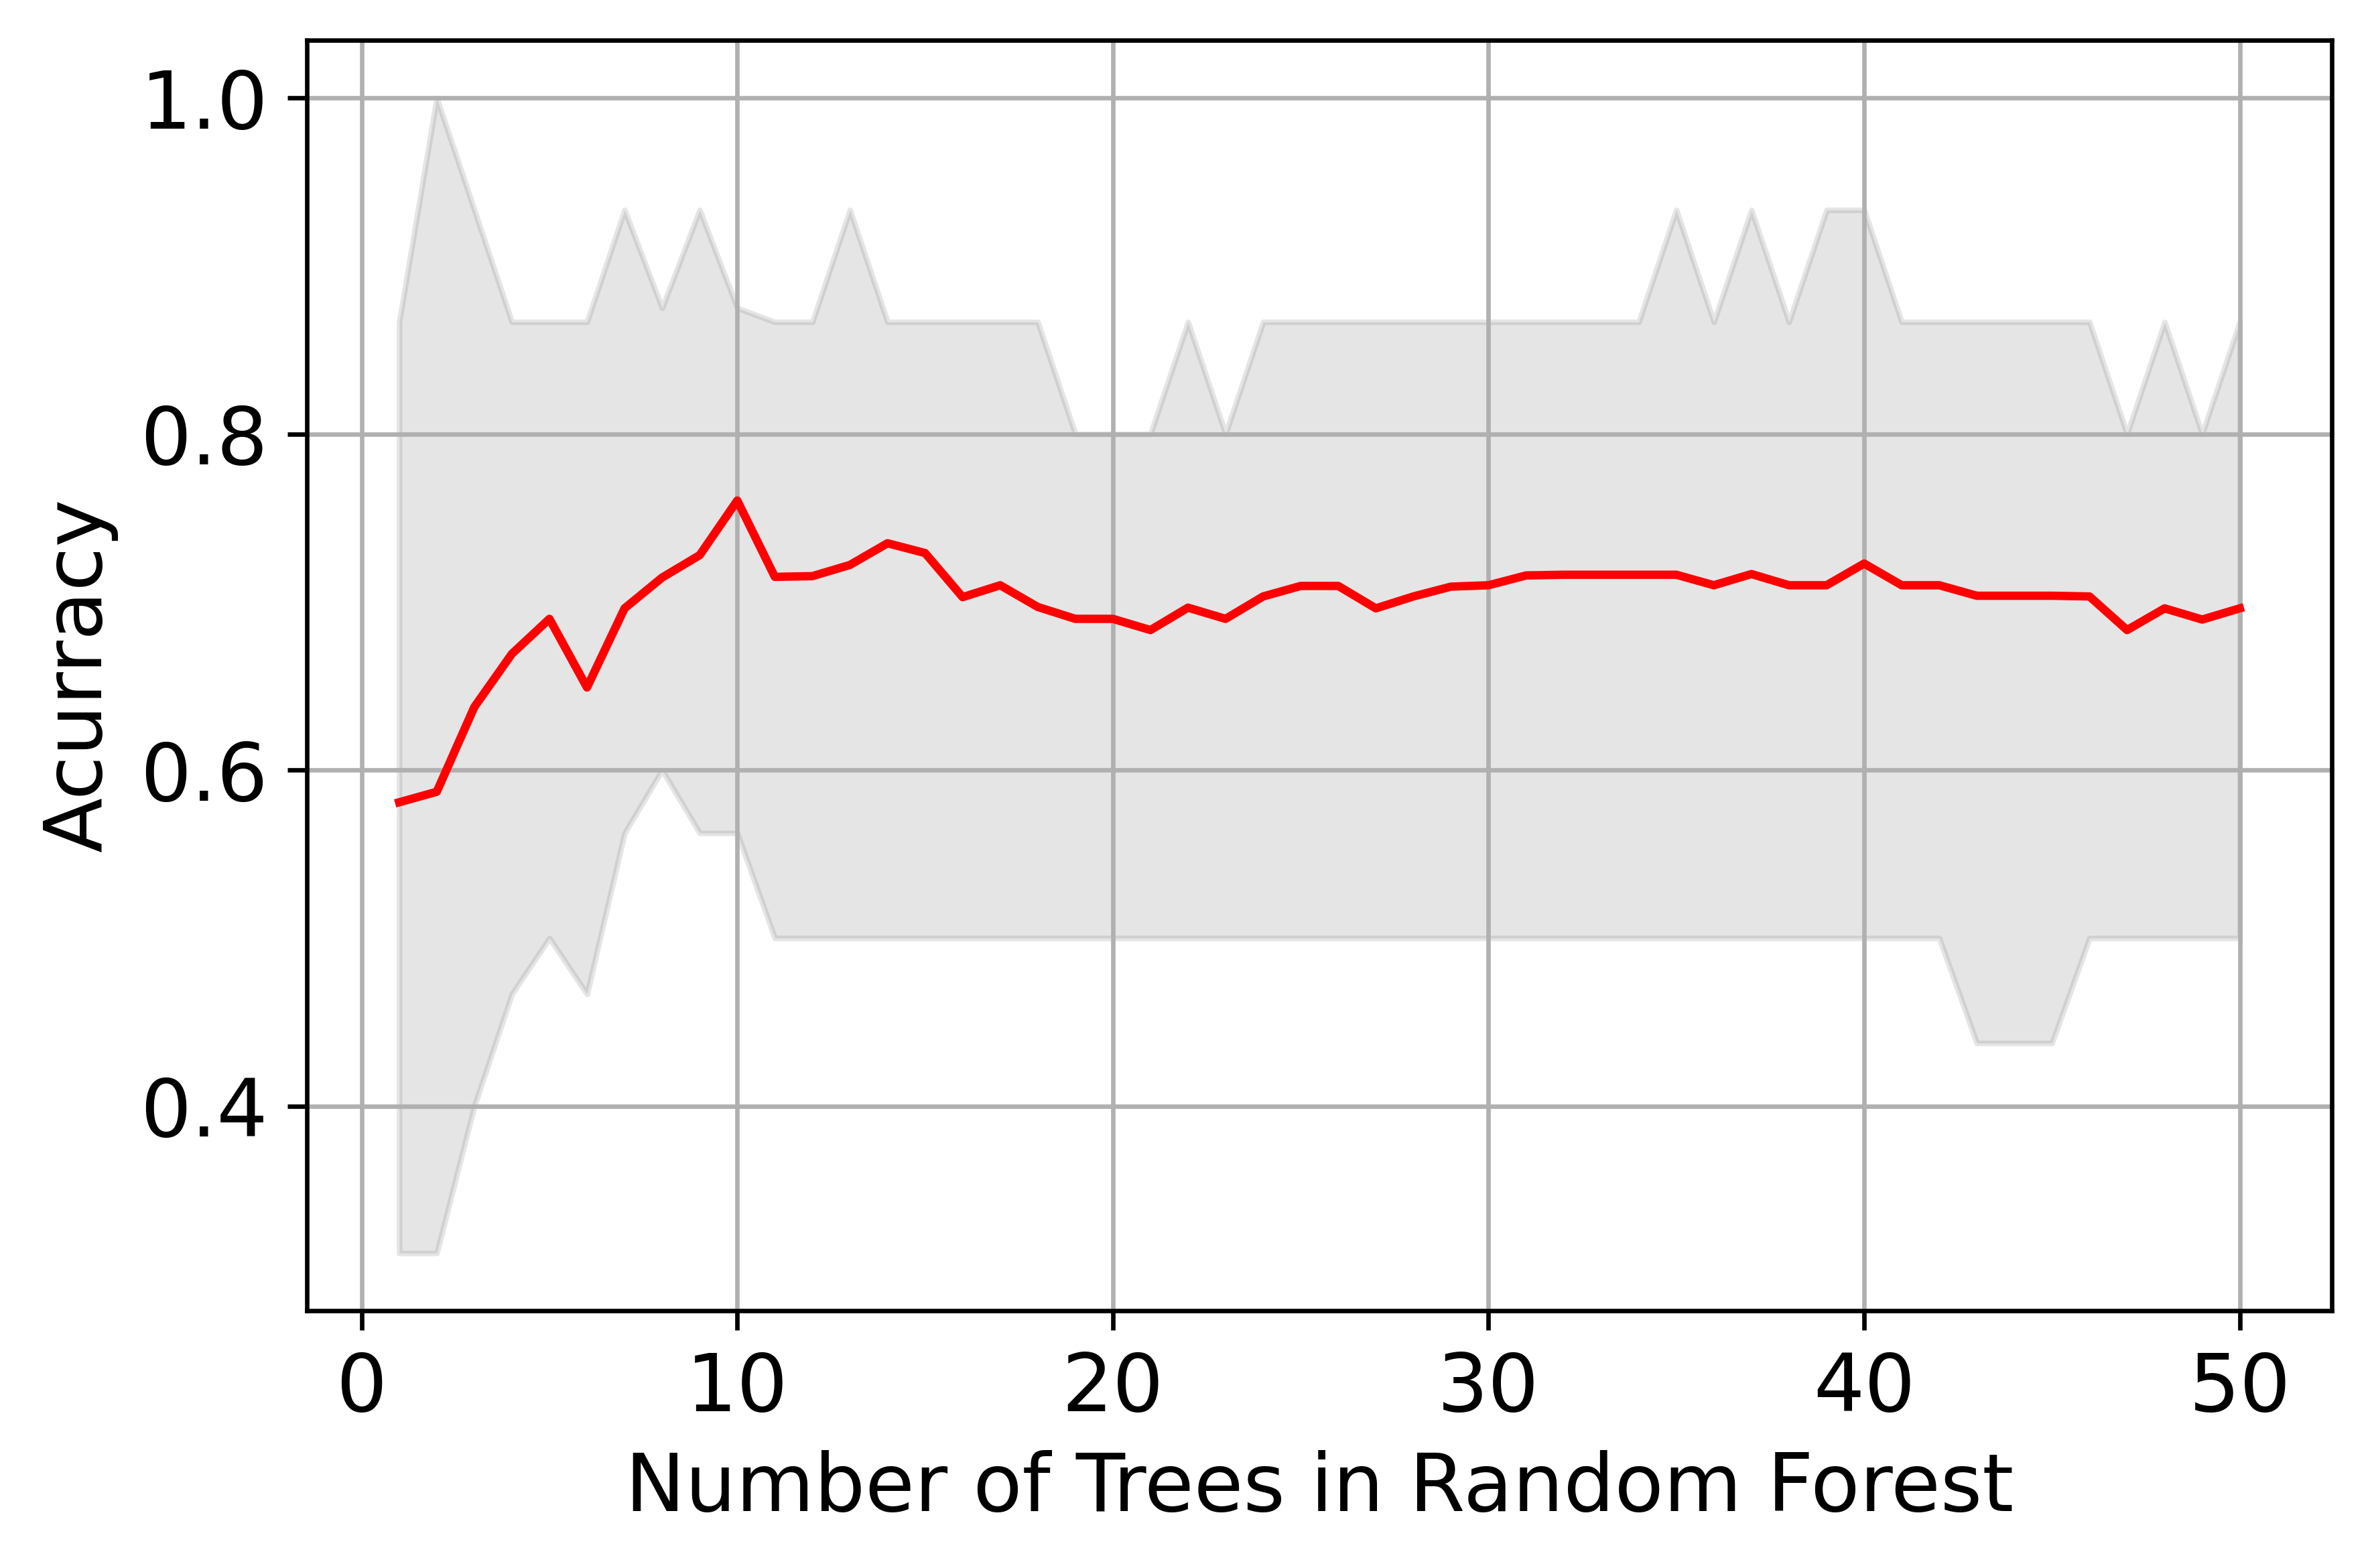

In [9]:
'''
Plot a Number of Trees curve in Random Forest vs Accuracy, for the 24 most important attributes
Helps to understand how performance varies with the number of trees
For each number of trees, apply cross-validation with 10 folds
'''

#Select the 24 best attributes
sel_k     = SelectKBest(f_classif, k=24)
data_less = sel_k.fit_transform(data_classification, Classes)

scr = []
ntrees = np.arange(1, 51)

for ntree in ntrees:
  clf = RandomForestClassifier(random_state=0, n_estimators=ntree, criterion='entropy', class_weight='balanced')
  scores = cross_val_score(clf, data_less, Classes, cv=10, scoring='accuracy')
  acc = [np.mean(scores), np.min(scores), np.max(scores)]
  scr.append(acc)

scr = np.array(scr)

fig, ax = plt.subplots(dpi=600)
ax.plot(ntrees, scr[:,0], color='r')
ax.fill_between(ntrees, scr[:,1], scr[:,2], color='grey', alpha=.2)
plt.xlabel('Number of Trees in Random Forest')
plt.ylabel('Acurracy')
ax.grid()
plt.tight_layout()
plt.show()

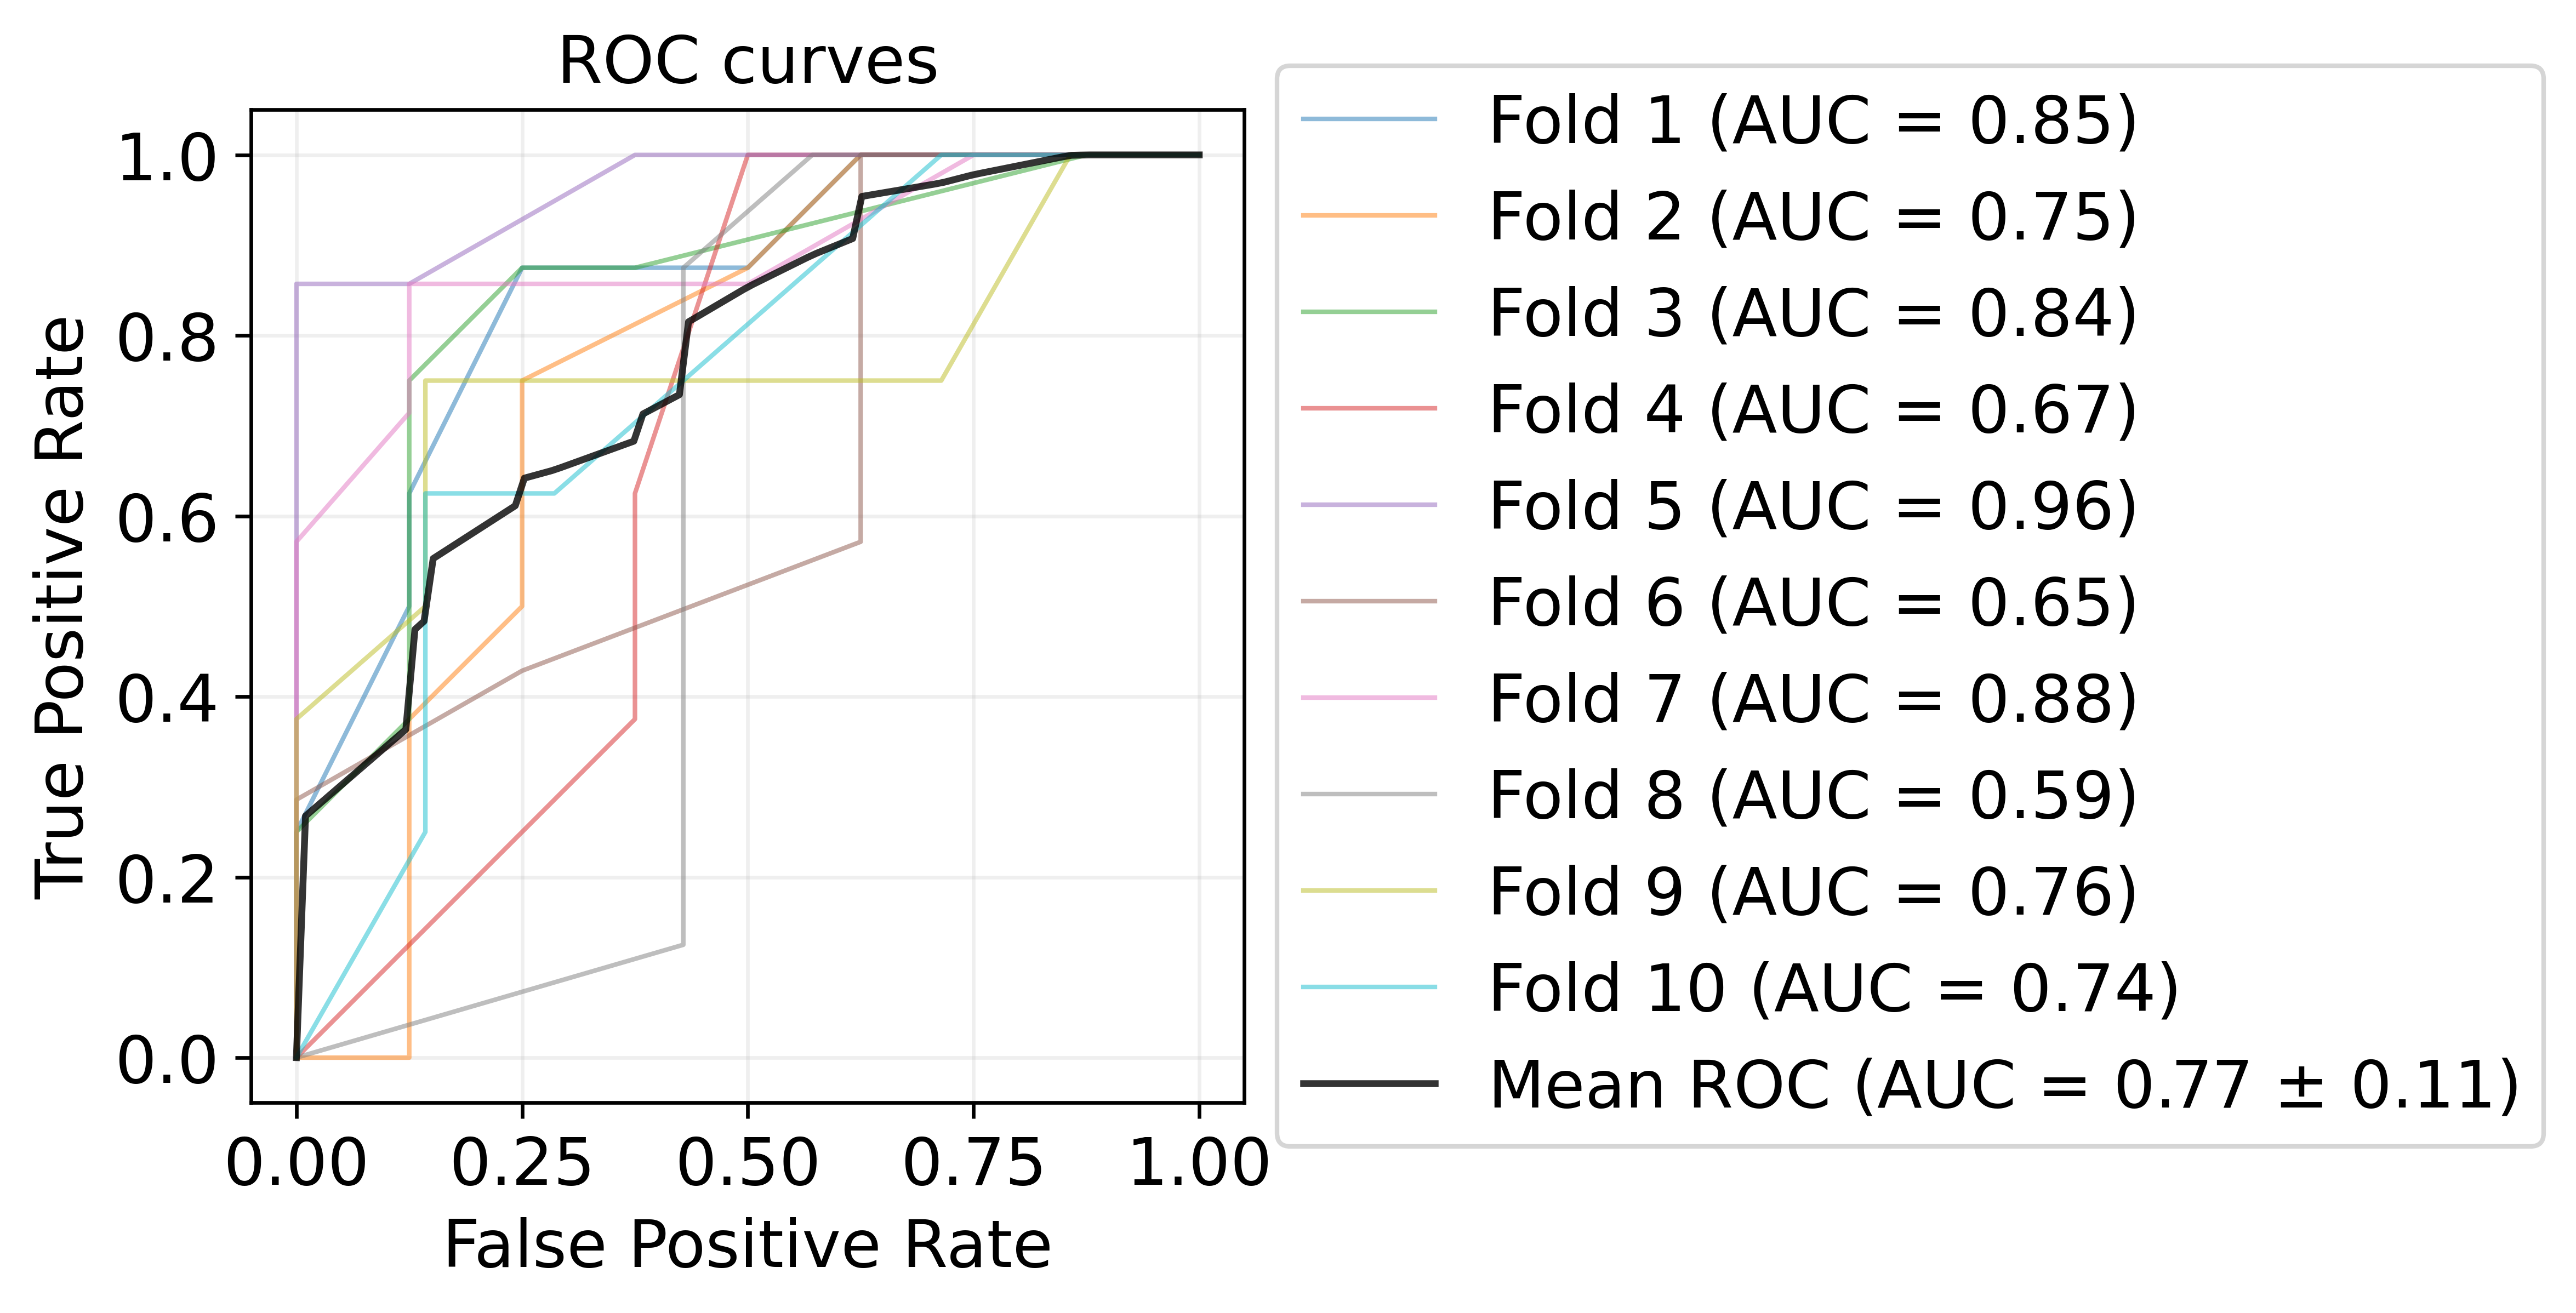

In [10]:
'''
Plot the ROC curve for the best RandomForest configuration
'''

#Best RandomForest
clf = RandomForestClassifier(random_state=0, n_estimators=10, criterion='entropy', class_weight='balanced')

cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(dpi=600)
for i, (train, test) in enumerate(cv.split(data_classification, Classes)):
    clf.fit(data_classification[train], Classes[train])
    viz = plot_roc_curve(clf, data_classification[test], Classes[test],
                         name='Fold {}'.format(i + 1),
                         alpha=0.5, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=1.5, alpha=.8, color='k')

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.set_title("ROC curves")
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(alpha=.2)
plt.show()

**Please cite this research accordingly: https://www.sciencedirect.com/science/article/abs/pii/S0378112721005867 or https://doi.org/10.1016/j.foreco.2021.119496**